In [2]:
import numpy as np
import matplotlib.pyplot as plt
from thesis_functions import build_generator_matrix, calculate_and_order_eigenspectrum

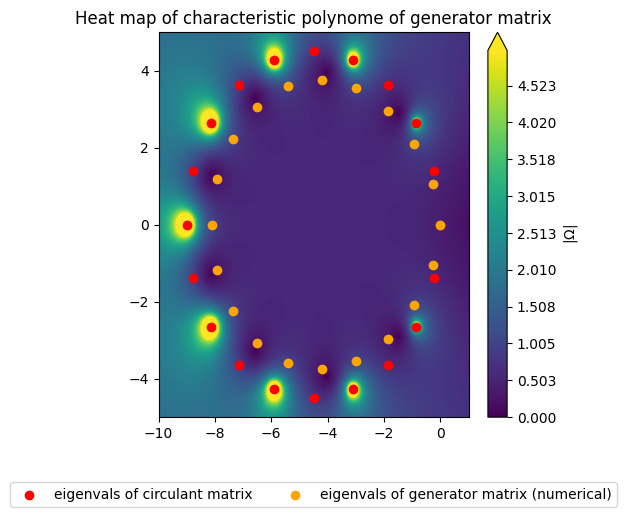

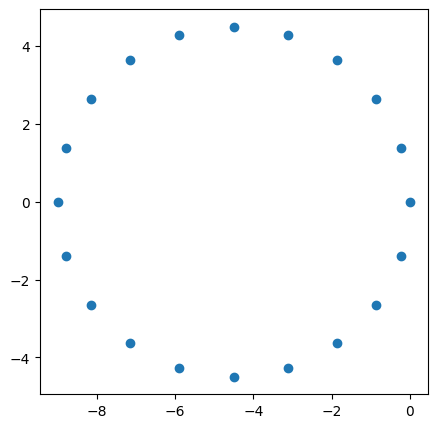

In [12]:
### This code visualizes the function whose zeros give the exact eigenvalues of my generator matrix

#Number of substates in each chain
N = 10
M = 10
#transition rates at end of each chain
r_ab = 1
r_ba = 1
refractory_periods = [2,2]
r = (N-1)/refractory_periods[0]

# Correct generator matrix with eigenspectrum
number_of_substates = [N,M]
transition_rates = [r_ab,r_ba]
#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)


roots_of_unity = np.array([np.exp(-(2*np.pi*1j*k)/(N+M)) for k in range(N+M)])
roots_of_circulant_matrix = -r*np.ones(len(roots_of_unity)) + r*roots_of_unity


def omega(x):
    sum = 0
    for j in range(N+M):
        phi_j = (2*np.pi*j)/(N+M)
        prefactor = (np.exp(-1j * phi_j) - 1)/(roots_of_circulant_matrix[j] - x) if x != roots_of_circulant_matrix[j] else 10**9
        postfactor = (r_ab - r) * (1 + np.exp(-1j*phi_j*M)) + (r_ba - r) * (1 + np.exp(1j*phi_j*M))
        sum += prefactor * postfactor

    return 1 + 1/(N+M) *sum

n_sampling = 400

Re = np.linspace(-10,1,n_sampling)
Im = np.linspace(-5,5,n_sampling)

RE, IM = np.meshgrid(Re, Im)

Z = RE + IM * 1j

# Compute Omega on grid
W_grid = np.zeros_like(Z)
for i in range(n_sampling):
    for j in range(n_sampling):
        W_grid[i,j] = omega(Z[i,j])

my_levels = np.linspace(0, 5, 200)

plt.contourf(RE, IM, np.abs(W_grid), cmap ='viridis', levels= my_levels, vmin = 0, vmax = 5,  extend='max')
plt.colorbar(label='$|\Omega|$')
plt.scatter(roots_of_circulant_matrix.real, roots_of_circulant_matrix.imag, color='red', label='eigenvals of circulant matrix')
plt.scatter(eigenvals.real, eigenvals.imag, color = 'orange', label='eigenvals of generator matrix (numerical)')
plt.legend(
    loc='upper center',       
    bbox_to_anchor=(0.5, -0.15), 
    ncol=2 
) 
plt.title('Heat map of characteristic polynome of generator matrix')                  
plt.show()



plt.rcParams["figure.figsize"] = [5,5]
plt.scatter(roots_of_circulant_matrix.real,roots_of_circulant_matrix.imag)
plt.show()


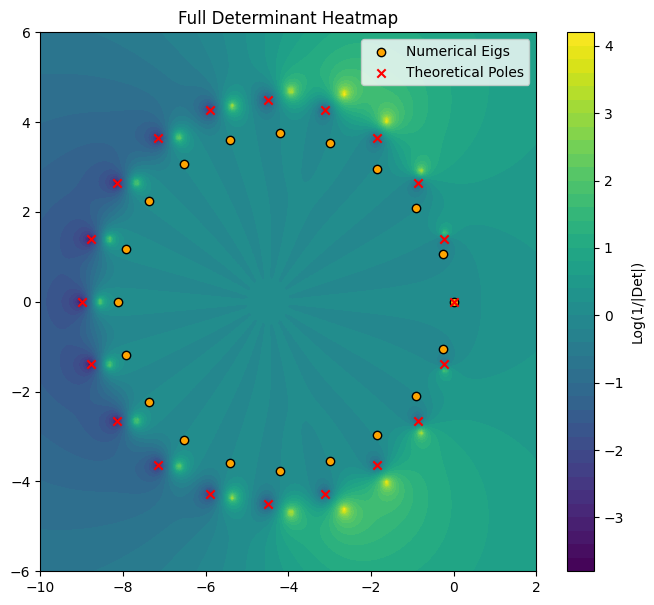

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
r_ab = 1.0     # Weak link
r_ba = 1.0
r = 4.5        # Fast ring
N = 10         # Length of chain A
M = 10         # Length of chain B
N_tot = N + M

# Unperturbed Eigenvalues (Directed Ring)
k_indices = np.arange(N_tot)
phi = (2 * np.pi * k_indices) / N_tot
mu_k = -r + r * np.exp(-1j * phi)

# --- 2. The Determinant Function (Captures ALL physics) ---
def get_determinant(z):
    # Denominator vector 1/(mu_k - z)
    # We add a tiny epsilon to avoiding division by zero errors in the plot
    denom = 1.0 / (mu_k - z + 1e-12)
    
    # Helper to calculate Sum[ G_rc ]
    # This sums the Green's function G(r, c)
    def get_G_sum(row_idx, col_idx):
        dist = row_idx - col_idx
        phase = np.exp(1j * phi * dist) 
        return (1/N_tot) * np.sum(phase * denom)

    # Defect parameters
    d1 = r_ab - r
    d2 = r_ba - r
    
    # Defect 1 coordinates (Source: N-1, Target: N)
    s1, t1 = N - 1, N
    # Defect 2 coordinates (Source: N+M-1, Target: 0)
    s2, t2 = N_tot - 1, 0

    # Build the 2x2 Matrix Elements (S_ij)
    # S00: Defect 1 acting on itself
    s00 = -d1 * get_G_sum(s1, s1) + d1 * get_G_sum(t1, s1)
    
    # S11: Defect 2 acting on itself
    s11 = -d2 * get_G_sum(s2, s2) + d2 * get_G_sum(t2, s2)
    
    # S01: Defect 2 acting on Defect 1 location
    s01 = -d1 * get_G_sum(s1, s2) + d1 * get_G_sum(t1, s2)
    
    # S10: Defect 1 acting on Defect 2 location
    s10 = -d2 * get_G_sum(s2, s1) + d2 * get_G_sum(t2, s1)

    # The Master Condition: Det(I + S)
    return (1 + s00) * (1 + s11) - (s01 * s10)

# --- 3. Numerical Ground Truth (for the orange dots) ---
L_brute = np.zeros((N_tot, N_tot))
for i in range(N_tot):
    t, s = i, (i - 1) % N_tot
    L_brute[t, t], L_brute[t, s] = -r, r
    
# Apply Defects
L_brute[N, N-1] = r_ab
L_brute[N-1, N-1] = -r_ab # Important: Fix conservation
L_brute[0, N_tot-1] = r_ba
L_brute[N_tot-1, N_tot-1] = -r_ba

eigvals_brute = np.linalg.eigvals(L_brute)

# --- 4. Visualization ---
re = np.linspace(-10, 2, 200)
im = np.linspace(-6, 6, 200)
RE, IM = np.meshgrid(re, im)
Z = RE + 1j * IM

# Compute the Determinant on the grid
W_val = np.zeros_like(Z)
for i in range(200):
    for j in range(200):
        W_val[i,j] = get_determinant(Z[i,j])

plt.figure(figsize=(8, 7))
plt.title("Full Determinant Heatmap")
# Plot 1/|Det| to make zeros look like peaks (or dark spots depending on cmap)
plt.contourf(RE, IM, np.log(1/np.abs(W_val)), levels=50, cmap='viridis')
plt.colorbar(label="Log(1/|Det|)")

# Overlap the Numerical Eigenvalues (Orange Dots)
plt.scatter(eigvals_brute.real, eigvals_brute.imag, c='orange', edgecolors='black', label='Numerical Eigs')
# Overlap the Theoretical Poles (Red Dots)
plt.scatter(mu_k.real, mu_k.imag, c='red', marker='x', label='Theoretical Poles')

plt.legend()
plt.show()